
ERT modeling and inversion in 2D
================================



Import necessary dependencies. <br/> pyGIMLi (www.pygimli.org) and PyBERT (https://pypi.org/project/PyBERT/) are used to create mesh, perform forward modeling and inversion.



In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore') # just to make it cleaner in the notebook
import numpy as np
import pybert as pb
import pygimli as pg
import pygimli.meshtools as mt  # save space
import pandas as pd
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

09/03/20 - 15:28:29 - tornado.application - ERROR - Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7f14bd6b8d40>)
Traceback (most recent call last):
  File "/home/stefan/anaconda3/envs/pybert/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/stefan/anaconda3/envs/pybert/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


Read the data file with apparent res from TIGRE <br/> Define the nr. of electrodes. <br/> Get the electrode spacing and the total number of measurements of $\rho_a$ <br/> Organise data in a numpy array

In [3]:
tigre_file="tigre_20_01_2020.dat"
# read header info :
with open(tigre_file, "r") as filin:
    headr=filin.read().splitlines()[0:6]
Nread=float(headr[3])
dx=float(headr[1])
filin.close()
# read data until end of file and strip the ending zeroes:
readings=[];
with open(tigre_file, "r") as filin:
    dada=filin.read().splitlines()[6:-1]
for line in dada:
    if line.strip("\n") != "0":
        readings.append(line.split())
filin.close()
readings=np.array(readings,dtype=np.float32)
first_spacing=readings[0,1]
Nel=2
for ri in readings:
    Nel=Nel+1 # Count Number of electrodes
    if ri[1] != first_spacing:
        break
#
display(pd.DataFrame(headr))
print("tot readings: ",Nread,"|| el. spacing dx= ",dx,"|| nr. of electrodes= ",Nel)

,0
0,w1 houghall: Line 1 / Spread 1
1,5
2,1
3,650
4,1
5,0


tot readings:  650.0 || el. spacing dx=  5.0 || nr. of electrodes=  64


In [4]:
# prepare sequence of electrode positions, PYBERT-unified style:
elpos=[]
for i in range(Nel):
    elpos.append([dx*i, 0, 0])
# Add synthetic topography:
elpos=np.asarray(elpos)
for i in range(Nel):elpos[i,2]=elpos[i,2]+10.*np.exp(-i*dx/20.)

In [5]:
# Convert Wenner mid-point of 4x and "a" value to index of electrodes in array.
# Organise resistivity and corresponding electrode indexes, PYBERT-unified style, in array abmnr:
abmnr=[]
for ree in readings:
    p1=int(round((ree[0]-ree[1]/2.)/dx))+1
    p2=int(round((ree[0]+ree[1]/2.)/dx))+1
    c1=int(round((ree[0]-3*ree[1]/2.)/dx))+1
    c2=int(round((ree[0]+3*ree[1]/2.)/dx))+1
    abmnr.append([c1,c2,p1,p2,ree[2]])

In [6]:
# Put all together in one file in PYBERT-unified format:
filout=tigre_file[:-4]+"_uni"+".dat" # name of output file
file_object = open(filout, 'w')
file_object.write(str(Nel)+"\n") # write nr. of electrodes in array
file_object.write("# x y z \n")  # write comment line 
for val in elpos:  # write x, y, z pos for each electrode:
    file_object.write(str(val[0])+"\t"+ str(val[1])+"\t"+ str(val[2])+"\n")
file_object.write(str(int(Nread))+"\n") # write total nr. of readings
file_object.write('# a b m n rhoa \n')  # comment line
for val in abmnr:  # write index of current electrodes (a,b), potential electrodes (m,n), and app.resistivity (r) 
    lin=str(val[0])+"\t"+str(val[1])+\
    "\t"+str(val[2])+"\t"+str(val[3])+\
    "\t"+str(val[4])
    file_object.write(lin+"\n")
file_object.write(str(0)) # append zero to signal end of data file

# Close the file
file_object.close()

In [7]:
# read-in the reformatted data file:
data=pb.importer.importData('tigre_20_01_2020_uni.dat')

09/03/20 - 15:28:33 - pyGIMLi - INFO - imported:  Data: Electrodes: 64 data: 650


In [8]:
# Run the ERTManager to invert the modeled data.
# The necessary inversion mesh is generated automatic.
ert = pb.ERTManager()

09/03/20 - 15:28:34 - pyGIMLi - WARNING - Module ps psutil not found.


In [9]:
import time
start_time = time.time()
print('starting inversion.... THIS MAY TAKE A FEW MINUTES...')
time.sleep(0.1)
#model = ert.invert(data, paraDX=10., maxCellArea=10.,lam=20)
model = ert.invert(data,lam=200,paraDX=100.0)
print('total cpu time for inversion : ',time.time()-start_time)

09/03/20 - 15:28:35 - pyGIMLi - INFO - estimate data error


starting inversion.... THIS MAY TAKE A FEW MINUTES...
creating mesh...
Mesh: Nodes: 917 Cells: 1664 Boundaries: 2580
Mesh: Nodes: 917 Cells: 1664 Boundaries: 2580
total cpu time for inversion :  24.896965503692627


<IPython.core.display.Javascript object>


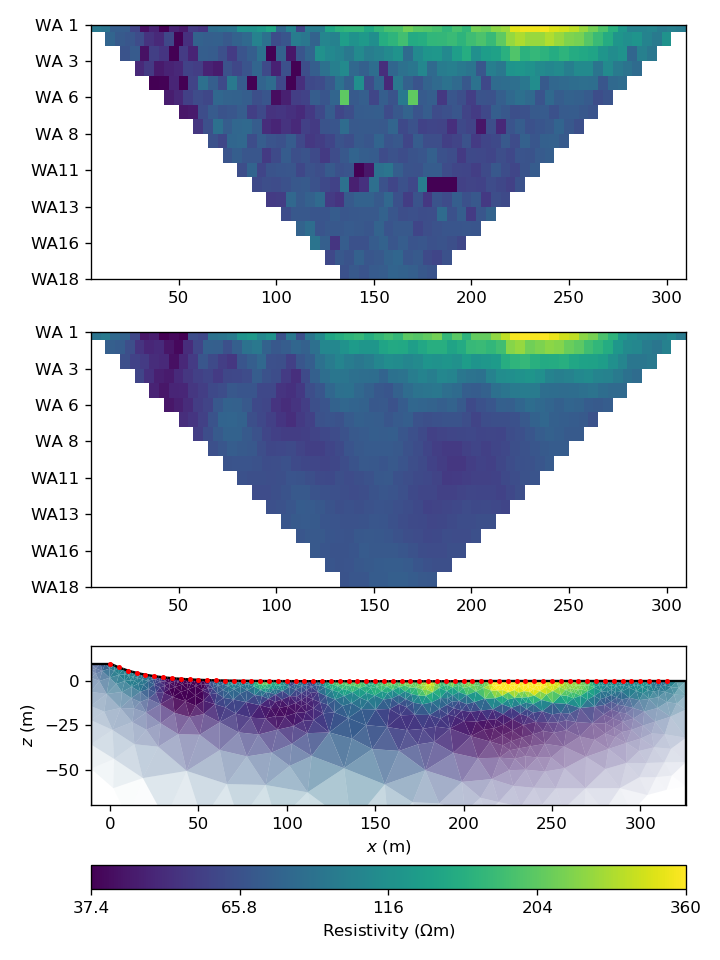

[(-70.0, 20.0)]

In [10]:
# Plot data of app.res., synthetic data of app.res. from inverted model, and result.
ert.showResultAndFit()
fig=plt.gcf();
fig.set_size_inches(6,8)
fig.tight_layout()
fig=plt.gcf()
fig.axes[2].plot(elpos[:,0],elpos[:,2],'ro',ms=2)
fig.axes[2].set(ylim=(-70.0, 20.0))

In [11]:
fig.savefig('houghall2020_res.pdf')

<IPython.core.display.Javascript object>


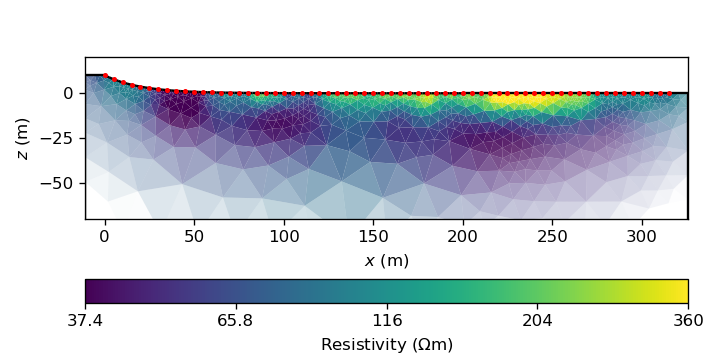

In [12]:
ert.showResult()
fig=plt.gcf()
fig.axes[0].plot(elpos[:,0],elpos[:,2],'ro',ms=2)
fig.axes[0].set(ylim=(-70.0, 20.0))
fig.set_size_inches(6,3);

## Show error / misfit

<IPython.core.display.Javascript object>


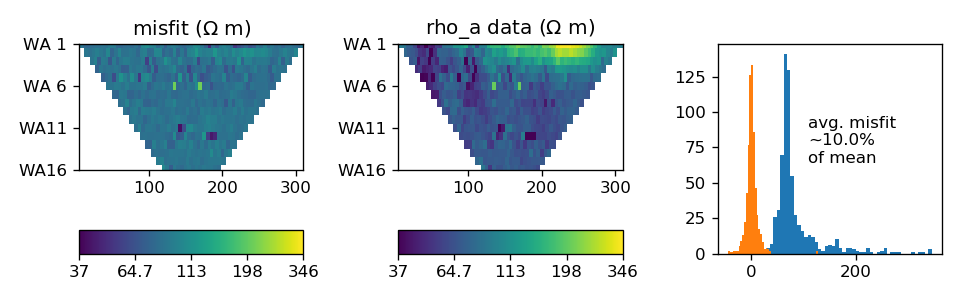

09/03/20 - 18:43:22 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'
09/03/20 - 18:43:22 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'


In [152]:
resp=ert.inv.response(); #retrieve the response from the inverted model
diff=np.asarray(readings[:,2])-np.asarray(resp); # compute difference with original data
fig,ax=plt.subplots(1,3,figsize=(8,2.5));
me=round(np.mean(diff),1);
mea=np.mean(np.abs(diff));
mava=max(readings[:,2]);miva=min(readings[:,2]);
miva=37;
#
sd=round(np.std(diff),1);
me2=round(np.mean(readings[:,2]),1);
sd2=round(np.std(readings[:,2]),1);
#
ert.showData(readings[:,2],ax=ax[1],cMin=miva,cMax=mava,cmap='viridis');
#ax[1].clim(-4,4)
ert.showData(diff+me2,ax=ax[0],cMin=miva,cMax=mava,cmap='viridis');
#fig,ax=plt.subplots()
#ax[1].text(8*sd,max(diff)/2,"st.dev. of misfit=\n"+str(sd)+" $\Omega$ m")
sd2=round(np.std(readings[:,2]),1);
ax[2].hist(readings[:,2],bins=50);
ax[2].hist(diff,bins=50);
perc=np.round((mea/me2),1)*100.
ax[2].text(me2+sd2/2,max(diff)/2,"avg. misfit\n~"+str(perc)+"%\n"+"of mean")
ax[1].set_title("rho_a data ($\Omega$ m)")
ax[0].set_title("misfit ($\Omega$ m)")
fig.tight_layout()

# Additional examples 

<IPython.core.display.Javascript object>


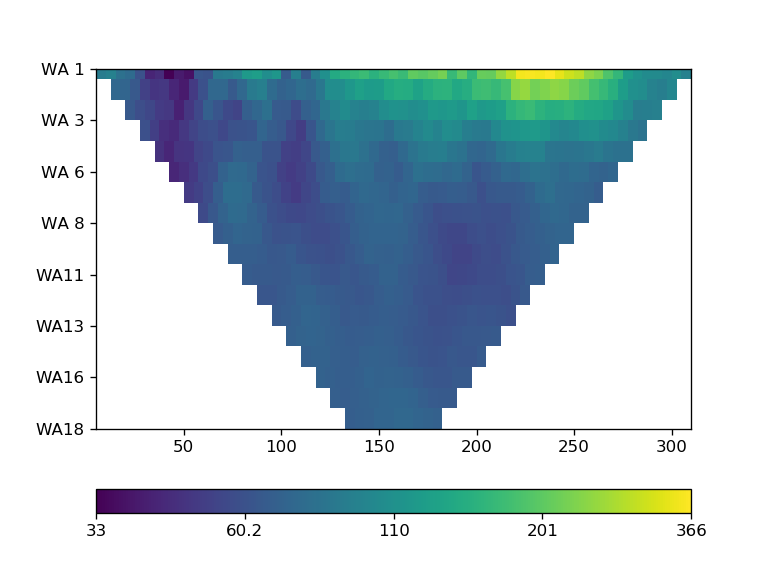

09/03/20 - 18:46:18 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'


<IPython.core.display.Javascript object>


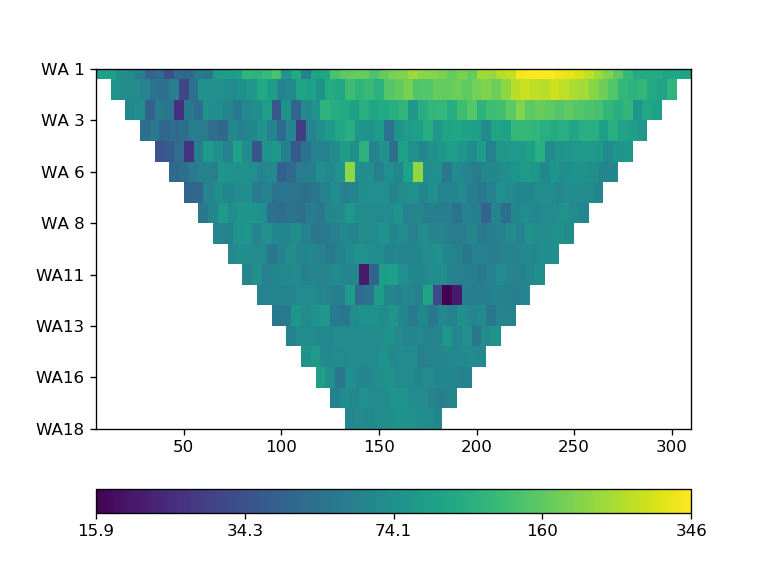

09/03/20 - 18:46:18 - pyGIMLi - WARNING - Keyword argument name changed from 'cmap' to 'cMap'


In [158]:
resp=ert.inv.response()
ert.showData(resp,cmap='viridis')
ert.showData(readings[:,2],cmap='viridis');

<IPython.core.display.Javascript object>


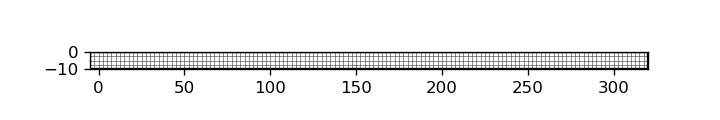

<IPython.core.display.Javascript object>


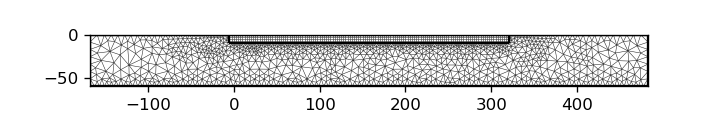

In [56]:
from pygimli.meshtools import appendTriangleBoundary
from pygimli.viewer import showMesh

#
dataC=pg.DataContainer('tigre_20_01_2020_uni.dat')
xmin=dataC.sensorPosition(0)[0]
xmax=dataC.sensorPosition(dataC.sensorCount()-1)[0]
dx=(dataC.sensorPosition(1)[0]-xmin ) /2.
nb = 2;zmax=10.
x = np.arange(xmin-dx*nb,xmax+dx*(nb+1), dx )
z = np.arange(-np.ceil ( zmax / dx ) , 1. )*dx 
mesh = pg.Mesh(2) # new 2d mesh
mesh.create2DGrid(x,z)
for c in mesh.cells():
    c.setMarker(2)#set all markers to 2
mesh2 = appendTriangleBoundary ( mesh , 50. , 50. ) # t h e main t h i n g !

showMesh(mesh);plt.gcf().set_size_inches(6,1);
showMesh(mesh2);plt.gcf().set_size_inches(6,1);